<a href="https://colab.research.google.com/github/PolMix/nems_ai/blob/main/Classic%20ML/shap_classic_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lib import

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import seaborn as sns

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

# Удобства
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Модели
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.base import clone

from xgboost import XGBRegressor

from IPython.display import clear_output

try:
    import shap
except ModuleNotFoundError:
    !pip install shap
    clear_output()
    import shap

# Метрики качества
from time import time

from sklearn.metrics import r2_score, mean_squared_error

# Обработка датасета, кроссвалидация
from sklearn.model_selection import train_test_split, KFold, cross_validate

# Нормировка датасета
from sklearn.preprocessing import RobustScaler, StandardScaler

# Скачивание данных и скриптов

Загружаем датасет с GitHub:

In [ ]:
import zipfile
import os

!wget --no-check-certificate \
    "https://github.com/PolMix/nems_ai/archive/refs/heads/main.zip" \
    -O "/tmp/data.zip"


zip_ref = zipfile.ZipFile('/tmp/data.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

--2023-06-05 08:13:32--  https://github.com/PolMix/nems_ai/archive/refs/heads/main.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/PolMix/nems_ai/zip/refs/heads/main [following]
--2023-06-05 08:13:32--  https://codeload.github.com/PolMix/nems_ai/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 20.27.177.114
Connecting to codeload.github.com (codeload.github.com)|20.27.177.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/data.zip’

/tmp/data.zip           [       <=>          ]  15.86M  6.52MB/s    in 2.4s    

2023-06-05 08:13:35 (6.52 MB/s) - ‘/tmp/data.zip’ saved [16625670]



In [ ]:
%cd '/tmp/nems_ai-main/Data Processed'
filename = 'Dataset_Processed.csv'
df = pd.read_csv(filename)
df = df.drop(columns='Unnamed: 0')
df.head()

/tmp/nems_ai-main/Data Processed


,Beam length (um),Beam width (nm),Thickness_1 (nm),Thickness_2 (nm),Temperature (K),Distance (nm),Gate voltage (V),Pretension (Pa),M1 Eigenfrequency (Hz),M1 Quality factor,...,M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 TED (W),M3 Noise (kg^2/s^3),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 TED (W),M4 Noise (kg^2/s^3)
0,10.666186,759.454713,192.911166,46.497924,19.089801,465.822644,28.323179,9.003567e+08,6.415102e+07,1.336133e+04,...,2.909667e+08,1.143351e+04,2.560363e-15,6.037978e-22,3.409430e-12,3.964520e+08,1.013999e+04,8.780197e-16,3.181145e-22,4.959458e-12
1,105.195552,890.696186,209.252268,37.407275,3.716553,314.636835,30.305477,5.090849e+08,2.569354e+06,7.177442e+06,...,8.224139e+06,5.740452e+06,3.281744e-14,8.720428e-28,1.367533e-11,1.152226e+07,5.003229e+06,3.291971e-14,1.406151e-27,1.583936e-11
2,10.310316,221.113532,195.903798,37.079461,0.027053,251.500693,26.675832,6.351363e+08,3.353110e+07,2.675673e+06,...,1.267642e+08,1.891218e+06,7.206070e-16,6.788349e-28,2.254001e-12,1.923697e+08,1.709827e+06,7.147747e-16,1.130223e-27,2.477637e-12
3,18.683573,282.662136,207.614117,18.750307,0.496423,172.245797,2.647445,0.000000e+00,1.049078e+07,8.772643e+06,...,4.475571e+07,8.332783e+06,1.623836e-15,6.849769e-28,2.943955e-12,7.057576e+07,8.000998e+06,1.616668e-15,1.119973e-27,3.081568e-12
4,121.747842,991.550766,102.506945,29.297485,2.037235,415.471216,18.419812,8.374213e+08,2.649739e+06,7.314592e+06,...,8.269131e+06,6.082613e+06,2.259615e-14,2.331664e-28,2.518650e-11,1.138111e+07,5.405428e+06,2.267905e-14,3.624442e-28,2.982471e-11


Скачивание файла с тестовым устройством из края распределений параметров:

In [ ]:
filename_test = 'Data_Processed_Boundary_Test.csv'
df_test = pd.read_csv(filename_test)
df_test = df_test.drop(columns='Unnamed: 0')
df_test.head()

,Beam length (um),Beam width (nm),Thickness_1 (nm),Thickness_2 (nm),Temperature (K),Distance (nm),Gate voltage (V),M1 Eigenfrequency (Hz),M1 Quality factor,M1 Effective mass (kg),...,M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 Noise (kg^2/s^3),M3 TED (W),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 Noise (kg^2/s^3),M4 TED (W)
0,821.402113,897.519396,200.0,36.102266,2.248089,924.978487,39.775523,169003.789805,53781.219971,2.581146e-13,...,5.089901e+05,53640.722509,2.582148e-13,4.490996e-28,1.441984e-11,6.809541e+05,53577.353352,2.583005e-13,6.009473e-28,2.286573e-11
1,187.634453,482.065578,150.0,19.450374,161.773060,911.580688,10.599196,512665.917301,27829.840781,2.167964e-14,...,1.616819e+06,25729.966624,2.199621e-14,3.120787e-25,1.475224e-11,2.243525e+06,24670.596346,2.212375e-14,4.356675e-25,1.758884e-11
2,638.204045,242.947138,100.0,24.144951,3.181935,455.886263,15.074379,221111.869936,14575.916394,2.871363e-14,...,6.636297e+05,14574.507206,2.871555e-14,5.640215e-28,7.054148e-13,8.851790e+05,14573.764249,2.871377e-14,7.522689e-28,1.155275e-12
3,910.105786,675.544397,200.0,43.676386,107.099808,914.705274,8.740595,124047.991251,39709.542285,2.224241e-13,...,3.731338e+05,38154.086830,2.224716e-13,1.462375e-26,7.550186e-12,4.986630e+05,37426.945624,2.225221e-13,1.954104e-26,1.220765e-11
4,665.998773,627.258997,200.0,26.364768,0.970622,659.057305,0.787551,201641.652944,37627.851275,1.412254e-13,...,6.068425e+05,37612.298667,1.412640e-13,2.752680e-28,4.751424e-12,8.113547e+05,37608.207889,1.412993e-13,3.680917e-28,1.052563e-11


# Подготовка данных

Делаем несколько действий:
- разбиваем датасет на тренировочную + валидационную часть и тестовую часть
- разбиваем трен-вал датасет на X и Y данные
- разбиваем тест датасет на X и Y данные

In [ ]:
len_test = 0.2 # доля объектов на тренировку и валидацию из изначального датасета
len_val = 0.2 # доля объектов на валидацию из трен-вал датасета

mode_number = 4

df_trainval, df_test = train_test_split(df, test_size=len_test, random_state=42, shuffle=True)
df_train, df_val = train_test_split(df_trainval, test_size=len_val, random_state=42, shuffle=True)

Разделение данных на тренировочную, валидационную и тестовую части:

Разбиение подвыборок на X и Y данные:

In [ ]:
%cd '/tmp/nems_ai-main/Scripts'
from dataset_preprocessing_pandas import split_df

x_train, y_train = split_df(df_train, num_common=8)
x_val, y_val = split_df(df_val, num_common=8)
x_test, y_test = split_df(df_test, num_common=8)

print('Dataset has been split into parts with the following shapes:')
print(f'x_train: {x_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'x_val: {x_val.shape}')
print(f'y_val: {y_val.shape}')
print(f'x_test: {x_test.shape}')
print(f'y_test: {y_test.shape}')

/tmp/nems_ai-main/Scripts
Dataset has been split into parts with the following shapes:
x_train: (3141, 8)
y_train: (3141, 20)
x_val: (786, 8)
y_val: (786, 20)
x_test: (982, 8)
y_test: (982, 20)


In [ ]:
x_test.head()

,Beam length (um),Beam width (nm),Thickness_1 (nm),Thickness_2 (nm),Temperature (K),Distance (nm),Gate voltage (V),Pretension (Pa)
4153,49.308200,782.896481,188.132818,26.635533,39.776275,218.106779,14.971359,3.142405e+08
3543,192.137428,518.376180,207.654824,15.361588,14.690520,358.705745,17.274668,0.000000e+00
907,58.299798,519.390602,200.345532,16.901881,264.175611,263.652628,23.487618,0.000000e+00
2522,65.228068,534.583721,199.844154,17.919077,10.055709,590.683389,30.865407,5.533608e+08
3107,419.836754,346.292481,209.354864,44.989361,1.196841,283.956739,17.091576,3.264575e+08


In [ ]:
y_train.head()

,M1 Eigenfrequency (Hz),M1 Quality factor,M1 Effective mass (kg),M1 TED (W),M1 Noise (kg^2/s^3),M2 Eigenfrequency (Hz),M2 Quality factor,M2 Effective mass (kg),M2 TED (W),M2 Noise (kg^2/s^3),M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 TED (W),M3 Noise (kg^2/s^3),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 TED (W),M4 Noise (kg^2/s^3)
3781,8.234588e+05,2.205309e+06,3.358069e-14,1.007442e-29,2.962872e-12,1.652589e+06,2.179432e+06,3.360062e-14,2.047043e-29,1.705975e-11,2.492992e+06,2.138282e+06,3.363194e-14,3.150402e-29,2.224337e-11,3.350131e+06,1.953502e+06,3.366659e-14,4.638795e-29,2.730320e-11
2200,3.620573e+07,1.264815e+05,1.630021e-15,2.647570e-23,3.616754e-12,8.950608e+07,8.741688e+04,1.780460e-15,1.034411e-22,3.956188e-12,1.634791e+08,6.489439e+04,1.773305e-15,2.534792e-22,4.171862e-12,2.560639e+08,5.143171e+04,1.759506e-15,4.970636e-22,4.369109e-12
4798,4.018177e+06,6.465237e+07,1.022956e-14,9.568429e-31,1.024539e-11,8.167046e+06,6.037550e+07,1.029027e-14,2.094931e-30,1.748103e-11,1.256789e+07,5.489475e+07,1.036000e-14,3.569687e-30,2.206222e-11,1.732588e+07,4.940941e+07,1.039743e-14,5.487195e-30,2.605582e-11
963,4.495736e+07,4.020745e+04,2.375713e-15,3.250626e-26,3.480341e-12,1.127357e+08,3.688876e+04,2.603435e-15,9.736272e-26,3.848615e-12,2.067481e+08,3.532490e+04,2.583663e-15,1.850441e-25,4.200149e-12,3.232575e+08,3.457247e+04,2.556074e-15,2.924626e-25,4.656986e-12
3965,3.016408e+06,1.090949e+09,2.947338e-14,5.105655e-33,9.305841e-13,6.131970e+06,1.006085e+09,2.964966e-14,1.132194e-32,5.494210e-12,9.438750e+06,8.997463e+08,2.985198e-14,1.962020e-32,1.288137e-11,1.301669e+07,8.200638e+08,2.995975e-14,2.979387e-32,1.521141e-11


Выполняем логарифмирование и скейлинг:

In [ ]:
from dataset_preprocessing_pandas import Scaler as Scaler

scaler_x = StandardScaler()
scaler_y = StandardScaler()

mode_number = 4
s = Scaler(scaler_x, scaler_y, mode_number)
s.fit(x_train=x_train, y_train=y_train)

x_train, y_train = s.transform(x_train, y_train)
x_val, y_val = s.transform(x_val, y_val)
x_test, y_test = s.transform(x_test, y_test)

In [ ]:
y_test.describe()

,M1 Eigenfrequency (Hz),M1 Quality factor,M1 Effective mass (kg),M1 TED (W),M1 Noise (kg^2/s^3),M2 Eigenfrequency (Hz),M2 Quality factor,M2 Effective mass (kg),M2 TED (W),M2 Noise (kg^2/s^3),M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 TED (W),M3 Noise (kg^2/s^3),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 TED (W),M4 Noise (kg^2/s^3)
count,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000
mean,0.008397,-0.014167,-0.006174,0.025109,0.013023,0.008054,-0.013916,-0.006343,0.024551,0.002942,0.007557,-0.014963,-0.006363,0.024660,-0.004944,0.007016,-0.007708,-0.006983,0.021198,-0.008800
std,0.988296,0.961995,0.980944,0.988541,0.984973,0.989626,0.963986,0.980410,0.990055,0.982179,0.990671,0.964596,0.980489,0.990604,0.972298,0.991183,0.973177,0.982377,0.995477,0.968027
min,-2.210503,-2.607106,-2.922469,-2.305750,-3.902680,-2.127390,-2.584861,-2.962526,-2.293187,-4.179475,-2.081414,-2.565005,-2.962160,-2.289673,-4.170642,-2.053933,-2.643954,-2.904239,-2.465779,-4.017885
25%,-0.764214,-0.696085,-0.714197,-0.681071,-0.555324,-0.764181,-0.706019,-0.699185,-0.682143,-0.422503,-0.769533,-0.703914,-0.700720,-0.686954,-0.489975,-0.775452,-0.694660,-0.682452,-0.697956,-0.514381
50%,-0.023415,-0.068124,-0.015231,0.061847,0.294927,-0.050238,-0.053054,-0.015728,0.057023,0.173135,-0.075644,-0.052964,-0.015262,0.053236,0.093081,-0.088919,-0.047806,-0.002947,0.056189,0.043985
75%,0.712678,0.682357,0.743511,0.773055,0.726739,0.691099,0.700989,0.737272,0.761989,0.654429,0.713913,0.700747,0.735649,0.751653,0.632641,0.720316,0.716392,0.735474,0.738864,0.655614
max,2.345348,2.479744,2.259412,2.881269,2.064679,2.397605,2.476387,2.267635,2.878661,2.222553,2.403320,2.453312,2.266518,2.853652,2.301370,2.239074,3.003916,2.242780,2.784347,2.308940


# Визуализация распределения нормированных параметров

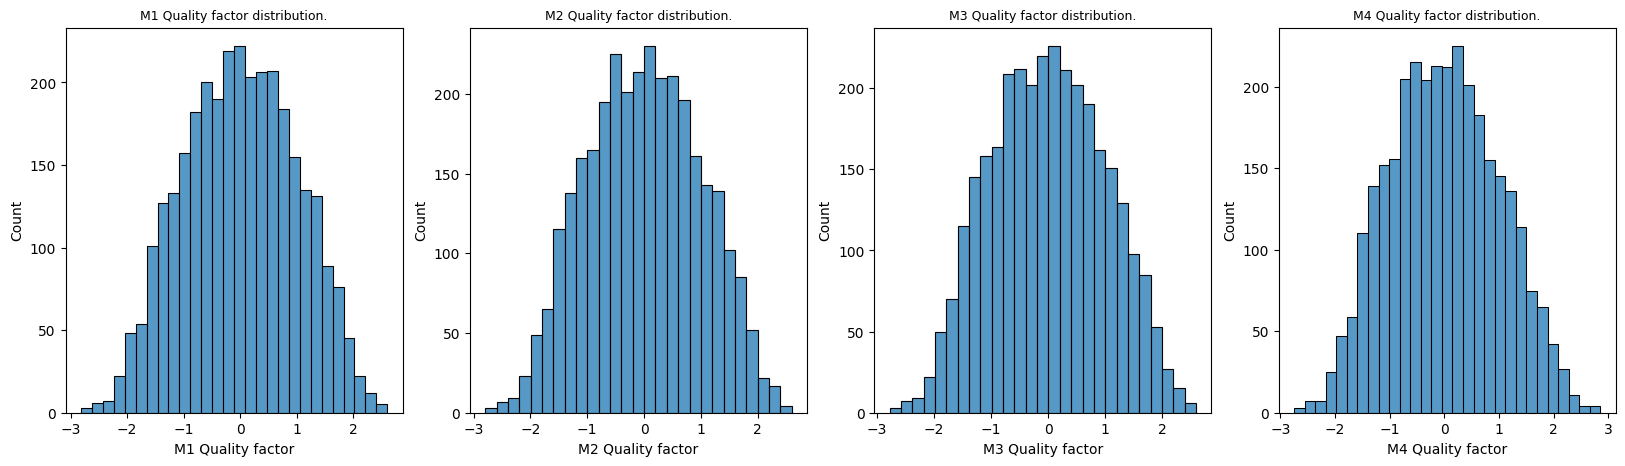

In [ ]:
from classic_ml import plot_distribution

plot_distribution(df=y_train, param_name='Quality factor',
                  log_scale=False, font_size=0.25)

# Обучение моделей

### Импорт необходимых скриптов

In [ ]:
%cd '/tmp/nems_ai-main/Scripts'
from classic_ml import get_elapsed_time, calculate_metrics
from classic_ml import plot_metrics, plot_metrics_dense, compare_models

/tmp/nems_ai-main/Scripts


### `XGBRegressor`:

In [ ]:
# Full dataset params
params = {'max_depth': 4, 'learning_rate': 0.058736919301307394, 'n_estimators': 584, 'min_child_weight': 8, 'gamma': 0.014285497344490779, 'subsample': 0.7531664932484148, 'reg_alpha': 0.0032198501861636798, 'reg_lambda': 3.7172242115107922e-06, 'n_jobs': -2}

model_boost = XGBRegressor(**params)
model_boost.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.014285497344490779, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.058736919301307394, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=8, missing=nan, monotone_constraints=None,
             n_estimators=584, n_jobs=-2, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
y_pred_train = model_boost.predict(x_train)
y_pred_val = model_boost.predict(x_val)
y_pred_test = model_boost.predict(x_test)

print("MSE на тренировочном наборе: {:.3f}".format(mean_squared_error(y_train, y_pred_train)))
print("MSE на валидационном наборе: {:.3f}".format(mean_squared_error(y_val, y_pred_val)))
print("MSE на тестовом наборе: {:.3f}".format(mean_squared_error(y_test, y_pred_test)))

print("R2 на тренировочном наборе: {:.3f}".format(r2_score(y_train, y_pred_train)))
print("R2 на валидационном наборе: {:.3f}".format(r2_score(y_val, y_pred_val)))
print("R2 на тестовом наборе: {:.3f}".format(r2_score(y_test, y_pred_test)))

print('Metrics dict:')
boost_metrics = calculate_metrics(y_true=y_test, y_pred=y_pred_test)
for key, value in boost_metrics.items():
    print(key, ' : ', value)

boost_mse_test = mean_squared_error(y_test, y_pred_test)
boost_r2_test = r2_score(y_test, y_pred_test)

MSE на тренировочном наборе: 0.004
MSE на валидационном наборе: 0.014
MSE на тестовом наборе: 0.014
R2 на тренировочном наборе: 0.996
R2 на валидационном наборе: 0.986
R2 на тестовом наборе: 0.986
Metrics dict:
M1 Eigenfrequency (Hz)  :  [0.0007760506469459226, 0.9992046502270161]
M1 Quality factor  :  [0.024404808880730447, 0.9736019063630857]
M1 Effective mass (kg)  :  [0.001726590632448059, 0.9982038461211213]
M1 TED (W)  :  [0.00593256485529801, 0.9939229097989424]
M1 Noise (kg^2/s^3)  :  [0.021432101024536517, 0.9778864483046463]
M2 Eigenfrequency (Hz)  :  [0.0007160325654361367, 0.9992681316666668]
M2 Quality factor  :  [0.021277296893462475, 0.9770798537245683]
M2 Effective mass (kg)  :  [0.001808240833086713, 0.9981168560156922]
M2 TED (W)  :  [0.005156096218807289, 0.9947344364050663]
M2 Noise (kg^2/s^3)  :  [0.0299246799925086, 0.9689479289015658]
M3 Eigenfrequency (Hz)  :  [0.0007159946112411442, 0.9992697140165114]
M3 Quality factor  :  [0.021953689626962626, 0.976381115228

Время работы модели:

In [ ]:
print(get_elapsed_time(model=model_boost, x=x_train))

0.052278757095336914


Визуализация метрик:

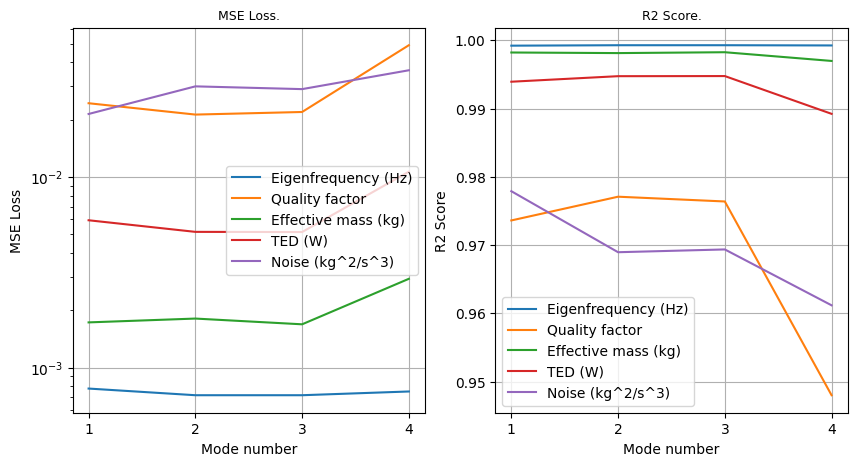

In [ ]:
plot_metrics_dense(output_dict=boost_metrics,
                   apply_log_mse=True, apply_log_r2=False,
                   font_size=1.5)

# Анализ чисел Шепли

Инициализация визуализации:

In [ ]:
shap.initjs()

Берем случайный массив входных данных:

In [ ]:
x_shap = x_train.sample(n = 100, random_state=42)

Работа с числами Шепли:

In [ ]:
explainer = shap.TreeExplainer(model=model_boost)
shap_values = explainer.shap_values(x_shap)

In [ ]:
# print(shap_values)

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[0], x_shap.iloc[0, :], matplotlib=True)

Для получения всех графиков из курсовой работы поочередно меняйте `param_index`  = 0, 1, ..., 4

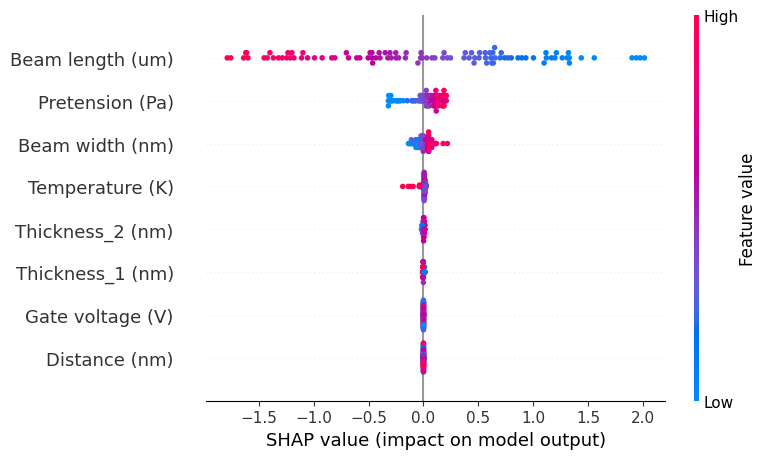

In [ ]:
param_index = 0
plot_indices = [0, 1, 2, 3, 4, 5, 6, 7]

shap.summary_plot(shap_values=shap_values[param_index][:, plot_indices],
                  features=x_shap.iloc[:, plot_indices])